# Standard Reservoir Computer (paper version)

### (single Lorenz system $\rho = 185$ )
### (bug fixed on VPT computation)

In [27]:
# Import libraries
import math
import numpy    as np
import networkx as nx

## variables description
    D       :(int  ) Input data dimension      
    N       :(int  ) Reservoir dimension (degrees of freedome of the reservoir)       
    rhoSR   :(float) Spectral Radius of A      
    rhoA    :(float) Density of A              
    alpha   :(float) Leak (or leakage) rate in (0,1]                 
    sigma   :(float) Strength of input signal            
    sigmab  :(float) Strength of input bias               
    beta    :(float) Tichonov-Miller regularization parameter
    
    washout :(int)   During training, skipped transitory timesteps in W_out calculation
    spinup  :(int)   Time (n. of timesteps) it takes for a trained RC to converge from its initial condition
                     onto the synchronization manifold to which it is driven by the input data
    normtime:(int)   Range to skip some QR factorisations and speed up the calculations  
            
    r       :(float) Reservoir state
    W_in    :(float) Input matrix              
    A       :(float) Reservoir ajacency matrix 
    b       :(float) bias vector               
    W_out   :(float) Output matrix  
    endtr_r :(float) Last reservoir state in training
    
    R       :(float) Matrix containing r(t) for all t in training dataset
    U       :(float) Matrix containing u(t) for all t in training dataset
    u       :(float) Time series at time t
    v       :(float) Prediction


In [28]:
# ReservoirComputer class declaration
class ReservoirComputer:
    def __init__(self, D, N, rhoSR, rhoA, alpha, sigma, sigmab, beta):
        self.r      = np.zeros(N)
        self.W_in   = get_random_matrix(N, D, xa=-sigma, xb=sigma, nonzero=False)
        self.A      = generate_adjacency_matrix(N, rhoSR, rhoA)
        self.b      = sigmab * np.ones(N)
        self.W_out  = np.zeros((D,N))
        self.endtr_r= np.zeros(N)

    def rc_update_rule(self, y):
        # driven     mode: y = u(t)         ;r(t+1) = F^d_r (r(t),y)
        # autonomous mode: y = W_out . r(t) ;r(t+1) = F^a_r (r(t),y)
        g      = np.dot(self.A, self.r) + np.dot(self.W_in, y) + self.b
        self.r = alpha * np.tanh(g) + (1 - alpha) * self.r

    def update_v(self):
        return np.dot(self.W_out, self.r)

    def train(self, U, washout):
        steps = U.shape[0]
        R     = np.zeros((N, steps))
        for i in range(steps):
            R[:, i] = self.r
            u       = U[i]
            self.rc_update_rule(u)
        self.W_out = linear_regression(R[:,washout:], U[washout:], beta)
        self.endtr_r = self.r # save last training r state

    def spinup(self, U, steps):
        self.r = self.endtr_r # reset reservoir state
        if steps > 0:
            for i in range(steps):
                u = U[i]
                self.rc_update_rule(u) # driven mode
    
    def predict(self, steps):
        prediction = np.zeros((steps, D))
        for i in range(steps):
            v             = self.update_v()
            prediction[i] = v
            self.rc_update_rule(v)
        return prediction

    def rc_lyapunov_exponents(self, steps, dt, normtime):
        save_r = self.r # save r state
        self.r = self.endtr_r # reset r state
        lyap   = np.zeros((N,steps))
        M      = np.eye(N)
        W      = self.A + np.dot(self.W_in,self.W_out)
        j      = -1
        for i in range(steps):
            v     = self.update_v()
            self.rc_update_rule(v) # update r
            #
            g     = np.dot(W, self.r) + self.b
            DF    = alpha * np.dot(np.diag(1 - np.tanh(g)**2),W) \
                    + (1 - alpha) * np.eye(N)
            Mn    = np.dot(DF,M)
            if (i % normtime == 0):
                Q,Rii = np.linalg.qr(Mn)
                j     += 1
                lyap[:,j] = np.log(abs(np.diag(Rii)))
                M = Q
        L = np.sum(lyap,1) / ((j+1)*dt)    
        self.r = save_r # retrieve saved r_state
        return L

    def rc_conditional_lyapunov_exponents(self, U, dt, normtime):
        save_r = self.r # save r state
        self.r = np.zeros(N) # reset r state
        steps  = U.shape[0]
        lyap   = np.zeros((N,steps))
        M      = np.eye(N)
        j      = -1
        for i in range(steps):
            u       = U[i]
            self.rc_update_rule(u) # update r
            #
            g  = np.dot(self.A, self.r) + np.dot(self.W_in, u) + self.b
            DF = alpha * np.dot(np.diag(1 - np.tanh(g)**2),self.A) \
                 + (1 - alpha) * np.eye(N)
            Mn = np.dot(DF,M)
            if (i % normtime == 0):
                Q,Rii = np.linalg.qr(Mn)
                j     += 1
                lyap[:,j] = np.log(abs(np.diag(Rii)))
                M = Q
        CL = np.sum(lyap,1) / ((j+1)*dt)
        self.r = save_r # retrieve saved r_state
        return CL
    
# Helper functions
def generate_adjacency_matrix(N, rhoSR, rhoA):
    # Erdos-Reyni network
    graph = nx.gnp_random_graph(N, rhoA)
    adj   = nx.to_numpy_array(graph)
    # Ensure random_array is of the same shape as the graph adjacency matrix
    random_array = get_random_matrix(N, N, xa =-0.5, xb=0.5, nonzero=True)
    # Multiply graph adjacency matrix with random values
    rescaled     = adj * random_array
    return scale_matrix(rescaled, rhoSR)

def get_random_matrix(nrow, ncol, xa, xb, nonzero):
    B = np.zeros((nrow,ncol))
    for i in range(nrow):
        for j in range(ncol):
            if nonzero:
                while B[i,j] == 0:
                    B[i,j] = xa + (xb - xa) * np.random.rand()
            else:
                B[i,j] = xa + (xb - xa) * np.random.rand()
    return B

def scale_matrix(A, rhoSR):
    eigenvalues = np.linalg.eigvals(A)    # compute eigenvlaues
    sr = np.max(np.absolute(eigenvalues)) # compute spectral radius of A
    if sr > 0:
        A = A * rhoSR / sr                # rescaling matrix if A non zero
    return A

def linear_regression(R, U, beta=.0001): 
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))
    return np.dot(np.dot(U.T, Rt), inverse_part)


# Lorenz 1963 system
$$
\begin{split}
\dot{x} &= \sigma(y-x)\\
\dot{y} &= x(\rho-z)-y\\
\dot{z} &= xy - \beta z
\end{split}
$$


In [29]:
# Import libraries
import matplotlib.pyplot as plt              
from reservoirpy.datasets import lorenz

# Setting random seed for repeteability
rnd_seed = 167
np.random.seed(rnd_seed)
import random
random.seed(rnd_seed)

# Generating data set
dt            = 0.01 # time step duration (in time unit, aka delta_t)
duration_time = 125  # duration time

# Lorenz parameters
n_timesteps = round(duration_time / dt)
rho         = 185
sigma       = 10.
beta        = 8./3.
h           = dt     
x0 = [0. , 1., 0. ] # initial condition according to Lorenz's paper (1963)

# Other (optional) parameters to pass to the scipy.integrate.solve_ivp solver
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
method = 'LSODA'
atol   = np.ones(3) * 1e-12
rtol   = 1e-12
X      = lorenz(n_timesteps, rho, sigma, beta, x0, h,
                method = method, atol = atol, rtol = rtol)


In [30]:
# text strings for filenames
txt_seed = 'seed' + str(rnd_seed) 

txt_rho = (f'{rho:07.3f}').replace(".", "_")

print(txt_seed, txt_rho)

seed167 185_000


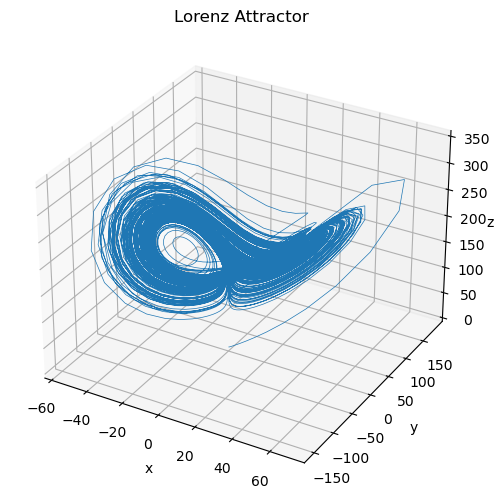

In [31]:
# Plot Lorenz attractor (entire dataset)
ax = plt.figure(figsize = (6, 6)).add_subplot(projection='3d')
ax.plot(X[:, 0], X[:, 1], X[:, 2], color = "C0", lw = 0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z", labelpad = -1.75)
ax.set_title("Lorenz Attractor")
plt.show()


In [32]:
# splitting in training and test dataset
data_length          = len(X) 
training_percentage  = .8
training_data_length = round(training_percentage * data_length) 
print("data_length          =",data_length)
print("training_data_length =",training_data_length)
training_data = np.array(X[:training_data_length])
test_data     = np.array(X[training_data_length:])


data_length          = 12500
training_data_length = 10000


In [33]:
# RC model instance
# RC model instance
# seed 42
#D      = 3
#N      = 400
#rhoSR  = 0.2
#rhoA   = 0.02
#alpha  = 0.8
#sigma  = 0.084
#sigmab = 1.1
#beta   = 8.5e-08

# seed 84
#D      = 3
#N      = 400
#rhoSR  = 0.5
#rhoA   = 0.02
#alpha  = 0.4
#sigma  = 0.084
#sigmab = 1.5
#beta   = 8.5e-08

# seed 167
D      = 3
N      = 400
rhoSR  = 0.5
rhoA   = 0.02
alpha  = 0.4
sigma  = 0.084
sigmab = 1.3
beta   = 8.5e-08

model   = ReservoirComputer(D, N, rhoSR, rhoA, alpha, sigma, sigmab, beta)

#---------------------------------------------------------------------#
# training
#---------------------------------------------------------------------#
washout = 100 # transitory skipped timesteps
model.train(training_data, washout)

#---------------------------------------------------------------------#
# test
#---------------------------------------------------------------------#
# The spinup time is the time it takes for a trained RC to converge
# from its initial condition (usually either set to zero or randomly 
# chosen) onto the synchronization manifold to which it is driven by
# the input data.
spinup_steps = 500

model.spinup(test_data, spinup_steps)
pred_steps = len(test_data) - spinup_steps    
pred_data = model.predict(pred_steps)


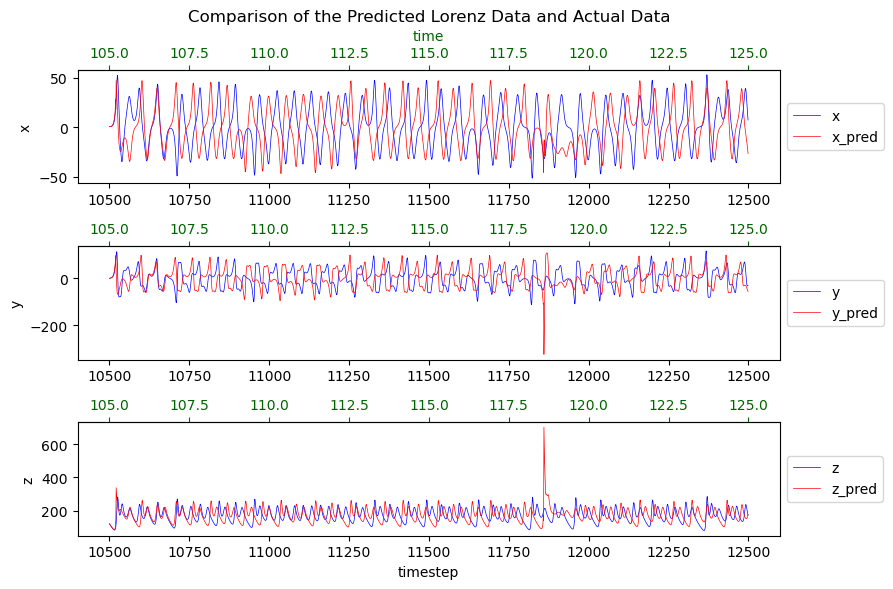

In [34]:
# Plot Lorenz variables (test and predicted dataset)
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

timesteps = [*range(training_data.shape[0] + spinup_steps, data_length, 1)] 

axis_test_label = ["x"     ,"y"     ,"z"     ]
axis_pred_label = ["x_pred","y_pred","z_pred"]
axs[0].set_title("Comparison of the Predicted Lorenz Data and Actual Data")

for i in range(D):
    axs[i].plot(timesteps, test_data[spinup_steps:,i], label= axis_test_label[i], color='blue', lw = 0.5)
    axs[i].plot(timesteps, pred_data[:,i]            , label= axis_pred_label[i], color='red' , lw = 0.5)
    #
    # add a secondary scale on variable x 
    ax = axs[i].secondary_xaxis('top', functions=(lambda x: dt * x, lambda x: x / dt), color = 'darkgreen')
    if i == 0:
       ax.set_xlabel('time')
    #
    axs[i].set_ylabel(axis_test_label[i])
    # Shrink current axis by 20%
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[2].set_xlabel("timestep")
fig.tight_layout()

plt.savefig('climate/seed' + str(rnd_seed) + '_rho_' + txt_rho + '_N400A.png',bbox_inches='tight')

plt.show()

plt.close(fig)


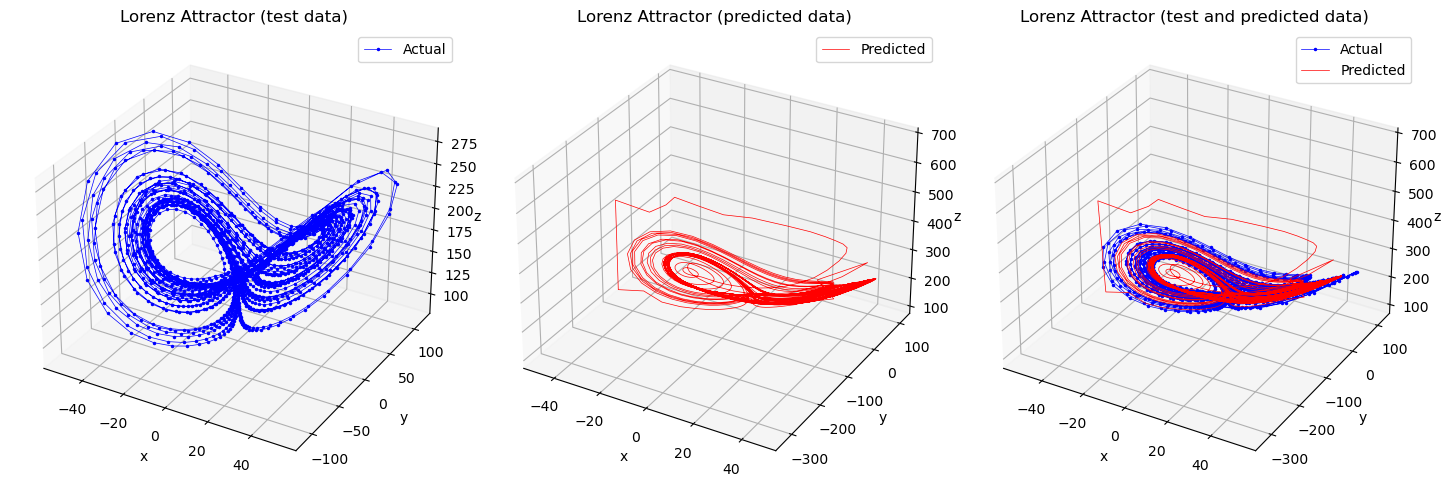

In [35]:
# Plot Lorenz attractors (test and predicted dataset)
#fig = plt.figure(figsize=(16,4))
fig = plt.figure(figsize=plt.figaspect(0.33))

titles = ["Lorenz Attractor (test data)",
          "Lorenz Attractor (predicted data)",
          "Lorenz Attractor (test and predicted data)"]

for i in range(len(titles)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    if i in [0,2]:
        ax.plot(test_data[spinup_steps:, 0], test_data[spinup_steps:, 1], test_data[spinup_steps:, 2],
                label="Actual"   , color = "blue", lw = 0.5, marker = '.',markersize = 3)
    if i in [1,2]:
        ax.plot(pred_data[:, 0], pred_data[:, 1], pred_data[:, 2],
                label="Predicted", color = "red" , lw = 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z", labelpad = -1.75)
    ax.legend()
    ax.set_title(titles[i])

fig.tight_layout()
plt.show()


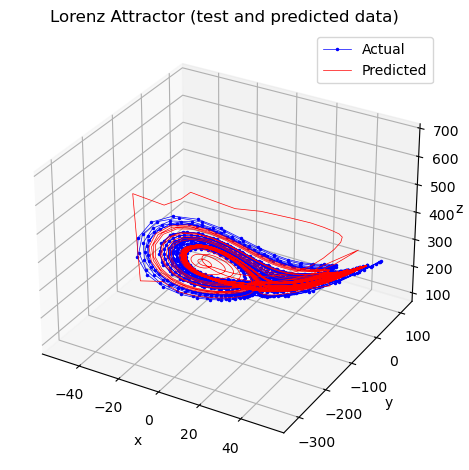

In [36]:
# Plot Lorenz attractors (test and predicted dataset)
#fig = plt.figure(figsize=(16,4))
fig = plt.figure(figsize=plt.figaspect(1))

titles = ["Lorenz Attractor (test data)",
          "Lorenz Attractor (predicted data)",
          "Lorenz Attractor (test and predicted data)"]

i = 2
ax = fig.add_subplot(1, 1, 1, projection='3d')
if i in [0,2]:
   ax.plot(test_data[spinup_steps:, 0], test_data[spinup_steps:, 1], test_data[spinup_steps:, 2],
           label="Actual"   , color = "blue", lw = 0.5, marker = '.',markersize = 3)
if i in [1,2]:
   ax.plot(pred_data[:, 0], pred_data[:, 1], pred_data[:, 2],
           label="Predicted", color = "red" , lw = 0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z", labelpad = -1.75)
ax.legend()
ax.set_title(titles[i])

fig.tight_layout()

plt.savefig('climate/seed' + str(rnd_seed) + '_rho_' + txt_rho + '_N400B.png',bbox_inches='tight')

plt.show()

plt.close(fig)


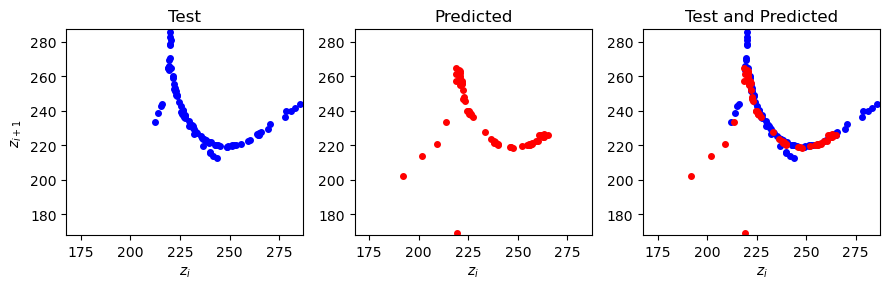

In [37]:
# Compute the return map of the z-coord of Lorenz system
# (test and predicted data)

from scipy.signal import find_peaks

test_z        = test_data[:, 2]
pred_z        = pred_data[:, 2]

test_peaks, _ = find_peaks(test_z, height=0)
tpks_len      = len(test_peaks)
pred_peaks, _ = find_peaks(pred_z, height=0)
ppks_len      = len(pred_peaks)

min_z_test    = min(test_z[test_peaks[0:tpks_len - 1]])
min_z_pred    = min(pred_z[pred_peaks[0:ppks_len - 1]])
min_z         = min(min_z_test,min_z_pred) - 1.5
max_z_test    = max(test_z[test_peaks[1:tpks_len]])
max_z_pred    = max(pred_z[pred_peaks[1:ppks_len]])
max_z         = min(max_z_test,max_z_pred) + 1.5

fig, rtm = plt.subplots(1, 3, figsize=(9, 3))  

rtm[0].plot(test_z[test_peaks[0:tpks_len - 1]], test_z[test_peaks[1:tpks_len]],"o",
            color='blue', markersize=4,)
rtm[0].set_ylabel("$z_{i+1}$")
rtm[0].set_xlabel("$z_i$")
rtm[0].set_xlim([min_z,max_z])
rtm[0].set_ylim([min_z,max_z])
rtm[0].set_title("Test")

rtm[1].plot(pred_z[pred_peaks[0:ppks_len - 1]], pred_z[pred_peaks[1:ppks_len]],"o",
            color='red', markersize=4,)
rtm[1].set_xlabel("$z_i$")
rtm[1].set_xlim([min_z,max_z])
rtm[1].set_ylim([min_z,max_z])
rtm[1].set_title("Predicted")

rtm[2].plot(test_z[test_peaks[0:tpks_len - 1]], test_z[test_peaks[1:tpks_len]],"o",
            color='blue', markersize=4,)
rtm[2].plot(pred_z[pred_peaks[0:ppks_len - 1]], pred_z[pred_peaks[1:ppks_len]],"o",
            color='red' , markersize=4,)
rtm[2].set_xlabel("$z_i$")
rtm[2].set_xlim([min_z,max_z])
rtm[2].set_ylim([min_z,max_z])
rtm[2].set_title("Test and Predicted")

fig.tight_layout()
plt.show()

In [38]:
# RMSE
from sklearn.metrics import mean_squared_error

axis_test_data = ["x","y","z"]
for i in range(3):
    print("RMSE",axis_test_data[i],"=",
          mean_squared_error(test_data[spinup_steps:,i],
                             pred_data[:,i], squared=False))


RMSE x = 31.689899508820407
RMSE y = 57.05472748397787
RMSE z = 59.50981464048018


In [39]:
# VPT (valid prediction time)
def valid_prediction_time(test_data, pred_data, std, threshold, dt):
    dsys     = len(std)
    len_data = len(test_data)
    vpt      = 0
    idx      = -1
    for i in range(len(test_data)):
        s = 0
        for j in range(dsys):
            s += ( (pred_data[i,j] - test_data[i,j]) / std[j])**2
        rmse_j_norm = math.sqrt(s/dsys)
        if (rmse_j_norm > threshold) or (i == (len(test_data) - 1)):
            vpt = i * dt
            idx = i
            break # skip loop if first occurrence > threshold
    return vpt, idx

# standardize training data (prevent data-leakage)
std = np.zeros(D)
for i in range(D):
    std[i] = np.std(training_data[:,i])
    
print("std          =", std)

e_threshold = 0.1
print("e_threshold  =", e_threshold)


std          = [21.49415394 39.63583784 39.66650227]
e_threshold  = 0.1


In [40]:
# Statistical ensemble of predictions 
# at different initial conditions (Platt, 2022)
e_threshold  = 0.1
n_samples    = 200
vpt_samples  = np.zeros(n_samples)
test_IC      = np.zeros((n_samples, D))
max_spinup   = len(test_data) - 500
for i in range(n_samples):
    spinup_steps = round(max_spinup * np.random.rand())
    model.spinup(test_data, spinup_steps)
    pred_steps = len(test_data) - spinup_steps    
    pred_data = model.predict(pred_steps)    
    vpt,idx     = valid_prediction_time(test_data[spinup_steps:],
                                        pred_data, std, e_threshold, dt)
    vpt_samples[i] = vpt
    test_IC[i] = test_data[spinup_steps]


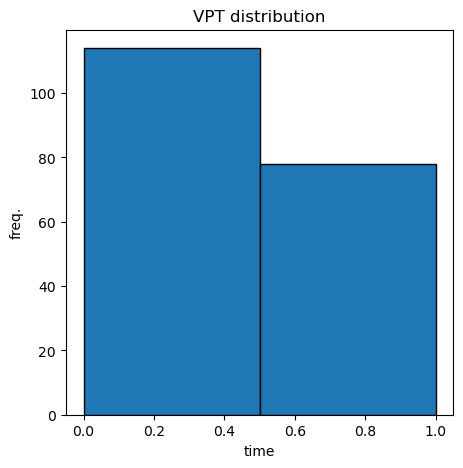

In [41]:
# VPT distribution
fig = plt.figure(1,figsize = (5,5))

bins = np.array ([i/2. for i in range(0,2*round(max(vpt_samples))+1) ])
plt.hist(vpt_samples,bins= bins,edgecolor="black", color="C0")
plt.xlabel("time")
plt.ylabel("freq.")
plt.title("VPT distribution") 

plt.show()

In [42]:
print("VPT mean =",np.mean(vpt_samples))
print("VPT std  =",np.std(vpt_samples))

VPT mean = 0.46869999999999995
VPT std  = 0.25758359808031256


This ensemble was generated by training an RC and then testing on a large number of initial conditions at different points over the Lorenz attractor. The variation in prediction time is partially due to the variation in the instability of the motion of the dynamical system. The Lorenz attractor has an unstable saddle point in the middle where it is extremely difficulty to predict which lobe the state will end up on, while the centers of the two lobes are quite stable (Platt, 2022).

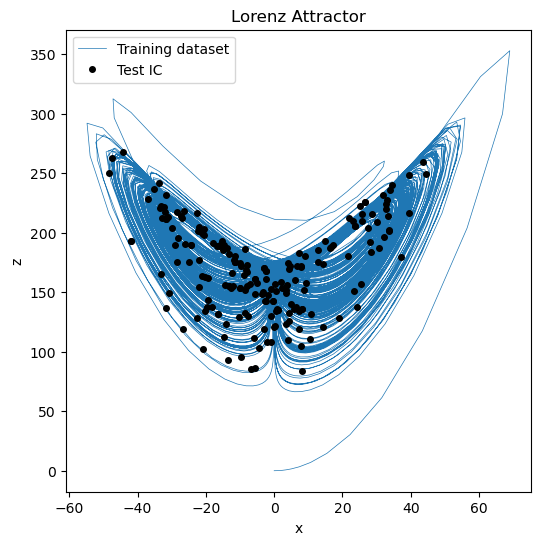

In [43]:
# Plot Lorenz attractor (training dataset) XZ
# Plot Test Initial Conditions
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.plot(X[:training_data_length, 0], X[:training_data_length, 2], 
        color = "C0"   , lw = 0.5, label="Training dataset")
ax.plot(test_IC[:,0], test_IC[:,2], "o", 
        color = "black", markersize=4, label="Test IC")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_title("Lorenz Attractor")
ax.legend()
plt.show()


In [44]:
# compute RC Lyapunov Exponents
normtime = 1
L = model.rc_lyapunov_exponents(len(test_data), dt, normtime)
print("First ",D,"RC Lyapunov Exponents")
print(L[:D])
print("RC Lyapunov Exponents")
print(L)


First  3 RC Lyapunov Exponents
[  0.93178202 -10.52098296 -47.72827488]
RC Lyapunov Exponents
[  0.93178202 -10.52098296 -47.72827488 -49.74415082 -50.36589705
 -50.44320224 -50.67118534 -50.53296443 -50.69324724 -50.58774803
 -50.71609526 -50.7701188  -50.74588934 -50.82664495 -50.83140801
 -50.79948901 -50.94523341 -50.83424363 -50.91082034 -50.82699549
 -51.07087913 -50.90235521 -50.89336378 -50.91597392 -50.92232643
 -50.89736499 -50.91809127 -50.97150043 -50.94597684 -50.95540154
 -51.04473999 -50.91386832 -51.02045307 -50.94278596 -50.93879481
 -50.9416279  -51.04163531 -50.9789725  -50.98487398 -50.98382227
 -50.9678883  -51.06780942 -50.99293378 -50.98313407 -51.02578095
 -50.98778686 -50.97569736 -51.07103841 -50.99944928 -50.98278395
 -50.99226409 -51.05108996 -51.11989827 -51.02671015 -50.9963015
 -51.12981701 -51.01675826 -51.06105404 -50.99895983 -51.01099272
 -51.04754166 -51.0624764  -51.03592031 -50.99648446 -51.07128265
 -51.01636021 -51.0288425  -51.05644901 -51.02507

In [45]:
# Kaplan-Yorke formula
def compute_DKY(L):
    LE  = np.sort(L)[::-1] # sort in descending order for safe
    sp  = 0
    sq  = 0
    DKY = 0
    # Python index starts from zero!
    if LE[0] > 0:
        for i in range(len(LE)-1):
            sp += LE[i]
            sq = sp + LE[i+1]
            if ((sp >= 0) and (sq < 0)):
               break
        DKY = (i+1) + sp/abs(LE[i+1]) 
    return DKY   

DKY = compute_DKY(L) 
print("Kaplan-Yorke dimension =",DKY)

Kaplan-Yorke dimension = 1.0885641602188483


In [46]:
# compute RC Conditional Lyapunov Exponents
normtime = 1
CL = model.rc_conditional_lyapunov_exponents(training_data, dt, normtime)
print("RC max CLE", np.max(CL))
print("RC Conditional Lyapunov Exponents")
print(CL)


RC max CLE -44.76807227030318
RC Conditional Lyapunov Exponents
[-44.76807227 -45.59864389 -47.29707502 -47.44488552 -48.04598312
 -48.11945445 -48.30022358 -48.43733346 -48.55416033 -48.91554717
 -49.14765838 -49.33756389 -49.43036305 -49.47816524 -49.54925949
 -49.62294369 -49.69196916 -49.67880668 -49.76169849 -49.78446011
 -49.85339661 -49.8524222  -49.90695876 -49.93805887 -49.97491622
 -50.01001243 -50.03878081 -50.07312157 -50.13292882 -50.19067279
 -50.20008912 -50.24304632 -50.29918446 -50.32705914 -50.3107201
 -50.32574169 -50.40652401 -50.42953829 -50.43275027 -50.46705583
 -50.48512832 -50.53275645 -50.5273278  -50.58129249 -50.60431822
 -50.6005448  -50.61379622 -50.64380818 -50.66807499 -50.65729208
 -50.70066226 -50.70524053 -50.74439507 -50.73453868 -50.75591261
 -50.76091374 -50.76905994 -50.79733072 -50.78749878 -50.81147211
 -50.82498101 -50.83236345 -50.83968776 -50.83589044 -50.871703
 -50.866463   -50.87523923 -50.8902356  -50.88067686 -50.92953628
 -50.89310562 -

### Alternative reservoir by setting degree k


In [47]:
# alternative reservoir (by setting degree k)
k = 6
m = round(k * N / 2)
graph = nx.gnm_random_graph(N, m)
adj   = nx.to_numpy_array(graph)
# Ensure random_array is of the same shape as the graph adjacency matrix
random_array = get_random_matrix(N, N, xa =-0.5, xb=0.5, nonzero=True)
# Multiply graph adjacency matrix with random values
rescaled     = adj * random_array
model.A = scale_matrix(rescaled, rhoSR)

avgdeg = np.mean(np.array(nx.degree(graph))[:,1])
avgdeg_alt = 2 * graph.size() / N
print("average degree =",avgdeg,avgdeg_alt)

average degree = 6.0 6.0


### Prepare image for paper

In [48]:
from PIL import Image, ImageDraw, ImageFont
from matplotlib import font_manager


In [49]:
im = Image.new('RGB',(1400, 600),'white')
draw = ImageDraw.Draw(im)


In [50]:
# comment these lines when development is over
#draw.rectangle((0, 0, 1399, 599), fill='white', outline='black')
#display(im)

In [51]:
im.save('rho_background.png', quality=95)

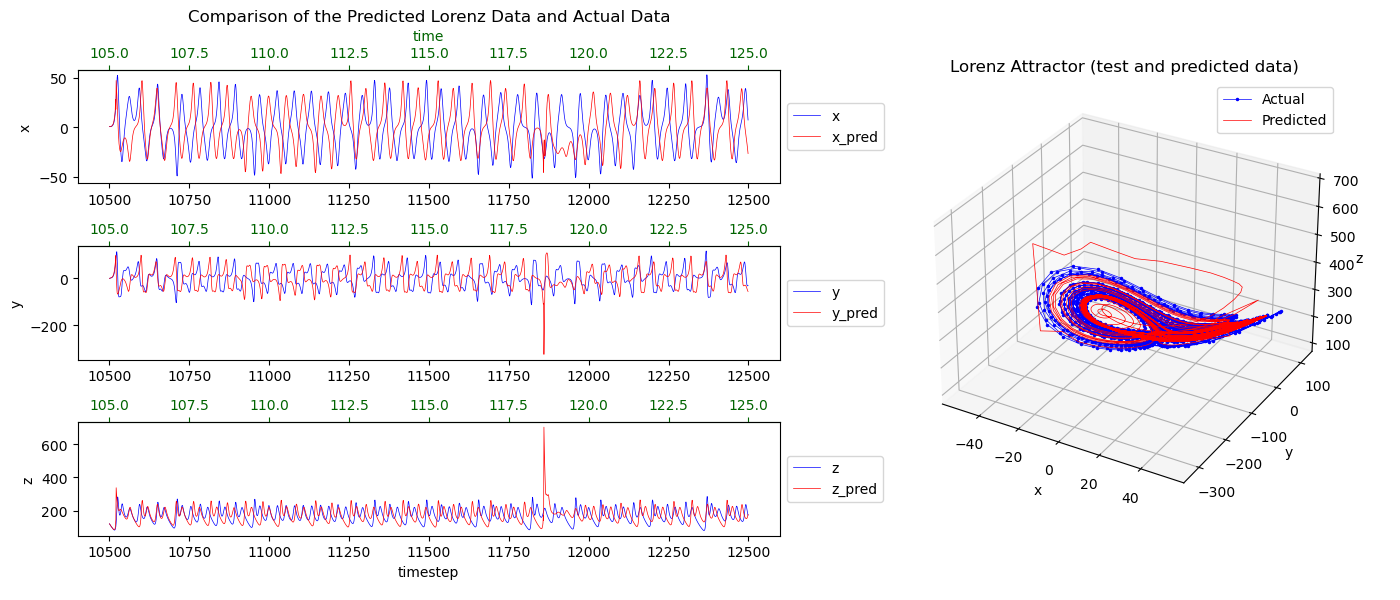

In [52]:
dx,dy = 0,0

# Overlap images

background  = Image.open("rho_background.png")
foreground  = Image.open('climate/' + txt_seed + "_rho_" + txt_rho + "_N400A.png")
foreground2 = Image.open('climate/' + txt_seed + "_rho_" + txt_rho + "_N400B.png")

background.paste(foreground, (0+dx, 0+dy), foreground)
background.paste(foreground2, (900+dx, 50+dy), foreground2)
display(background)
background.save('climate/' + txt_seed + '_rho_' + txt_rho + '_N400AB.png', quality=95)
